In [1]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit -*-
# -*- date : 2025-04-24 -*-
# -*- Last revision: 2025-05-02 by janzgraggen -*-
# -*- python version : 3.11.11 -*-
# -*- Description: Notebook that summarizeses the main results-*-

# <center> EE-452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Graph-based EEG Analysis </center>
---

In [2]:
#import libraries
import pandas as pd
from pathlib import Path
import sys

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

#import modules
import constants
from transform_func import *
from models.cnn_base import CnnBase
from dataloader import load_data
from utils import *

%load_ext autoreload
%autoreload 2

/home/nulpe/anaconda3/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [3]:
parent_dir = Path.cwd().resolve().parent.parent
os.chdir(parent_dir)

# Load Data

## Train

In [4]:
# cnn train data
cfg = read_yml('project/config/exp/cnn/basic_cnn.yml')
loader_train = load_data(cfg.get("datasets")[0])

In [18]:
%%time
# gml correlation graph train data
cfg = read_yml('project/config/exp/gml/basic_correlation_gml.yml')
loader_train = load_data(cfg.get("datasets")[0])

/home/nulpe/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


CPU times: user 8min 8s, sys: 1min 3s, total: 9min 12s
Wall time: 1min 57s


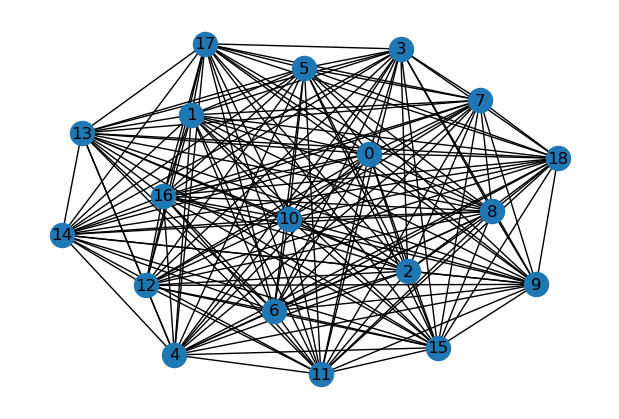

In [19]:
plt.figure(figsize=(6, 4))
G = to_networkx(loader_train.dataset[0][0], to_undirected=True, node_attrs=['signal'])
pos = nx.spring_layout(G,)  # or use any other layout
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()

In [20]:
%%time
# gml distance based graph train data
cfg = read_yml('project/config/exp/gml/basic_distance_gml.yml')
loader_train = load_data(cfg.get("datasets")[0])

CPU times: user 53.7 s, sys: 18.2 s, total: 1min 11s
Wall time: 53.8 s


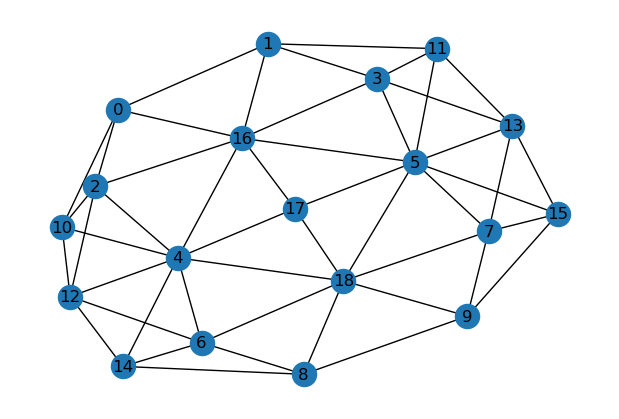

In [21]:
plt.figure(figsize=(6, 4))
G = to_networkx(loader_train.dataset[0][0], to_undirected=True, node_attrs=['signal'])
pos = nx.spring_layout(G,)  # or use any other layout
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()

## Validation

In [15]:
loader_val = load_data(cfg.get("datasets")[1])

## Test

In [16]:
loader_test = load_data(cfg.get("datasets")[2])

In [18]:
for test_images, test_labels in loader_test:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]

In [20]:
sample_label

tensor(0)

# Models

## Basic CNN

In [10]:
basic_cnn = CnnModel(input_shape=19, output_shape=1)

In [11]:
basic_cnn.train_model(loader_tr=loader_train, num_epochs=1)

Training: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


In [14]:
basic_cnn.create_submission(loader_test, 'test.csv')

Submission file created at test.csv


,id,label
0,tensor(0),0
1,tensor(0),0
2,tensor(0),0
3,tensor(0),0
4,tensor(0),0
...,...,...
3609,tensor(0),0
3610,tensor(0),0
3611,tensor(0),0
3612,tensor(0),0
